# 📑 FER2013 Dataset
The FER2013 dataset consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

<img src="https://user-images.githubusercontent.com/11619444/127019677-db8141b8-ab28-46de-a695-237fa894e227.png" width="500px" >

***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import cv2
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import (
    LearningRateScheduler,
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging (1 = INFO, 2 = WARNING, 3 = ERROR)

# Optional: Adjust Python logging as well
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#default_figsize = plt.rcParams.get('figure.figsize')
#scaled_figsize = [dimension * 1. for dimension in default_figsize]
#plt.rcParams['figure.figsize'] = scaled_figsize

# 🗂️ Load Dataset

In [3]:
working_dir = os.getcwd()
data = pd.read_csv(working_dir + "/fer2013.csv")
data.head(3)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training


In [4]:
print("=" * 75)
print("The number of the rows are: ", len(data))
print("There are null values in the dataset: ", data.isnull().values.any())
print("The different emotion labels are: ", list(data["emotion"].unique()))
print("The different types of sets are: ", list(data["Usage"].unique()))
print("The length of the training set is: ", len(data[data["Usage"] == "Training"]))
print("The length of the validation set is: ", len(data[data["Usage"] == "PrivateTest"]))
print("The length of the test set is: ", len(data[data["Usage"] == "PublicTest"]))
print("The number of duplicated images: ", len(data[data.duplicated(["pixels"], keep=False)]))
print("=" * 75)

The number of the rows are:  35887
There are null values in the dataset:  False
The different emotion labels are:  [0, 2, 4, 6, 3, 5, 1]
The different types of sets are:  ['Training', 'PublicTest', 'PrivateTest']
The length of the training set is:  28709
The length of the validation set is:  3589
The length of the test set is:  3589
The number of duplicated images:  3369


# 📊 Visualize dataset

In [5]:
def get_colors(color_map, n):
    cm = plt.cm.get_cmap(color_map, n)
    n_colors = [mcolors.rgb2hex(cm(i)) for i in range(cm.N)]
    return n_colors

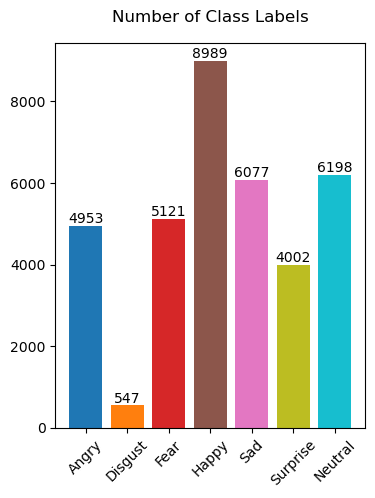

In [6]:
symbols = sorted(data["emotion"].unique())
emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
label_counts = data.emotion.value_counts()
counts = [label_counts[i] for i in range(len(symbols))]
plt.figure(figsize=(4,5))
plt.title("Number of Class Labels", fontsize=12, pad=15)
plt.bar(
    range(len(symbols)),
    counts,
    tick_label=emotions,
    color=get_colors("tab10", len(emotions)),
)
plt.xticks(rotation=45)
for symbol, count in zip(symbols, counts):
    plt.text(symbol, count, count, ha="center", va="bottom")

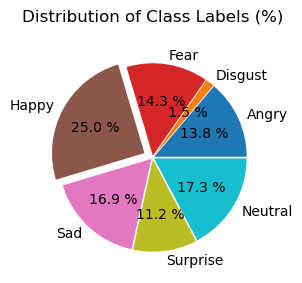

In [7]:
plt.figure(figsize=(3,3))
plt.title("Distribution of Class Labels (%)", fontsize=12, pad=15)
_ = plt.pie(
    x=counts,
    labels=emotions,
    autopct="%3.1f %%",
    colors=get_colors("tab10", len(emotions)),
    explode=tuple(
        [0.1 if x == np.argmax(counts) else 0.02 for x in range(len(counts))]
    )
)

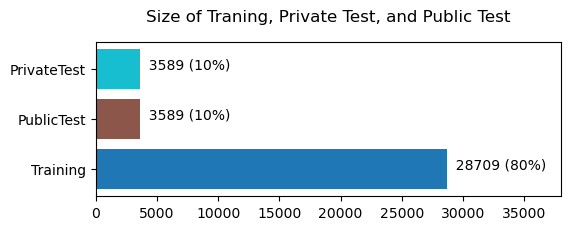

In [8]:
types = data["Usage"].unique()
type_counts = data["Usage"].value_counts()
type_counts = [type_counts[i] for i in range(len(type_counts))]
index = np.arange(len(type_counts))

fig, ax = plt.subplots(figsize=(6,2))
ax.set_title("Size of Traning, Private Test, and Public Test", fontsize=12, pad=15)
ax.barh(index, type_counts, color=get_colors("tab10", len(types)))
ax.set_yticks(index)
ax.set_yticklabels(types)
ax.set_xlim([0, 38000])

for i, v in enumerate(type_counts):
    ax.text(v, i, "  " + str(v) + " (" + "{:.0%}".format(v / np.sum(type_counts)) + ")")

# ⛏️ Preprocess Data

In [9]:
def to_square_image(images, size):
    image_list = []
    for i in range(len(images)):
        converted = np.array(images[i].split(" "), dtype=np.uint8)
        image_list.append(converted.reshape(size, size))
    return image_list

In [10]:
def to_rgb(image):
    result = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float32)
    result[:, :, 0] = image
    result[:, :, 1] = image
    result[:, :, 2] = image
    return result

In [11]:
def remap(column, mapping_rule):
    remapped = column.map(mapping_rule)
    return remapped

In [12]:
# Remove duplicates

duplicates_to_delete = data[data.duplicated(["pixels"], keep=False)]
data_cleaned = pd.concat([data, duplicates_to_delete]).drop_duplicates(keep=False)
data_cleaned = data_cleaned.reset_index()
data = data_cleaned

In [13]:
# Add emotion label column

column = data["emotion"]
mapping = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral",
}
remapped = remap(column, mapping)
data["emotion_label"] = remapped

In [14]:
# Add reshaped images column

pixels = data["pixels"]
images = to_square_image(pixels, 48)
data["images"] = images

In [15]:
print("=" * 75)
print("The number of the rows are: ", len(data))
print("There are null values in the dataset: ", data.isnull().values.any())
print("The different emotion labels are: ", list(data["emotion"].unique()))
print("The different types of sets are: ", list(data["Usage"].unique()))
print("The length of the training set is: ", len(data[data["Usage"] == "Training"]))
print("The length of the validation set is: ", len(data[data["Usage"] == "PrivateTest"]))
print("The length of the test set is: ", len(data[data["Usage"] == "PublicTest"]))
print("The number of duplicated images: ", len(data[data.duplicated(["pixels"])]))
print("=" * 75)

The number of the rows are:  32518
There are null values in the dataset:  False
The different emotion labels are:  [0, 2, 4, 6, 3, 5, 1]
The different types of sets are:  ['Training', 'PublicTest', 'PrivateTest']
The length of the training set is:  26006
The length of the validation set is:  3261
The length of the test set is:  3251
The number of duplicated images:  0


### Plot Images from the Dataset

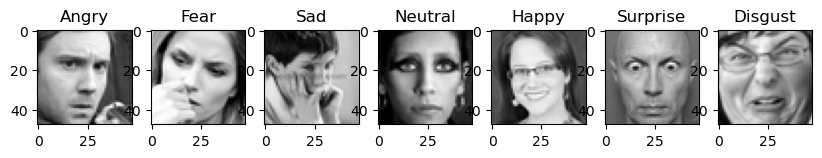

In [16]:
emotion_list = list(data["emotion_label"].unique())
fig, axs = plt.subplots(
    1, len(emotion_list), figsize=(10, 5), facecolor="w", edgecolor="k"
)
fig.subplots_adjust(hspace=1, wspace=0.2)
axs = axs.ravel()
for i in range(len(emotion_list)):
    axs[i].imshow(
        data[data["emotion_label"] == emotion_list[i]].iloc[0]["images"], cmap="gray"
    )
    axs[i].set_title(
        data[data["emotion_label"] == emotion_list[i]].iloc[0]["emotion_label"]
    )

### Save Preprocessed Data

In [17]:
working_dir = os.getcwd()
print(working_dir)

/Users/reka/Downloads


In [18]:
data_usage = data["Usage"].unique()
count = 0
try:
    for data_usage_type in data_usage:
        data_usage_folder_path = working_dir + "/" + data_usage_type
        os.mkdir(data_usage_folder_path)
        for emotion in emotions:
            emotion_folder_path = data_usage_folder_path + "/" + emotion
            os.mkdir(emotion_folder_path)
            for img in data[
                (data["Usage"] == data_usage_type) & (data["emotion_label"] == emotion)
            ]["images"]:
                plt.imsave(emotion_folder_path + "/" + str(count) + ".jpg", img, cmap='gray')
                count += 1
except FileExistsError:
    pass

# 🚀 Data Augmentation

In [19]:
def random_crop(image, size):
    height, width, _ = image.shape
    dy, dx = size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return image[y : (y + dy), x : (x + dx), :]

In [20]:
def crop_generator(batches, crop_length):
    while True:
        batch_x, batch_y = next(batches)
        crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 1))
        for i in range(batch_x.shape[0]):
            crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (crops, batch_y)

In [21]:
training_set_dir = working_dir + "/" + "Training"
validation_set_dir = working_dir + "/" + "PrivateTest"
batch_size = 32

In [22]:
train_data_gen_args = dict(
    rescale=1.0 / 255,
    featurewise_center=False,
    featurewise_std_normalization=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
validation_data_gen_args = dict(rescale=1.0 / 255)

image_datagen = ImageDataGenerator(**train_data_gen_args)
val_datagen = ImageDataGenerator(**validation_data_gen_args)

In [23]:
training_image_generator = image_datagen.flow_from_directory(
    training_set_dir, target_size=(52, 52), batch_size=batch_size, class_mode="sparse", color_mode="grayscale"
)

validation_image_generator = val_datagen.flow_from_directory(
    validation_set_dir, target_size=(52, 52), batch_size=batch_size, class_mode="sparse",  color_mode="grayscale"
)

train_crops = crop_generator(training_image_generator, 48)
validation_crops = crop_generator(validation_image_generator, 48)

Found 26006 images belonging to 7 classes.
Found 3261 images belonging to 7 classes.


In [24]:
print(training_image_generator.class_indices)

{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}


# 📈 Training

In [25]:
def get_model(input_shape=(48, 48, 1), classes=7, base_filters=32):
    model = Sequential()

    model.add(Conv2D(base_filters, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())

    model.add(Conv2D(base_filters * 2, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(base_filters * 4, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(base_filters * 4, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.15))

    model.add(Conv2D(base_filters * 8, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(base_filters * 8, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.15))

    model.add(Flatten())
    model.add(Dense(base_filters * 8, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation='softmax'))

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [26]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

In [27]:
model_cnn = get_model()
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                        

In [28]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="cp.ckpt",
    save_weights_only=True,
    verbose=1,
    save_best_only=True,
)

In [29]:
training_set_size = len(data[data["Usage"] == "Training"])
validation_set_size = len(data[data["Usage"] == "PrivateTest"])
print(
    "Traning set size: ",
    training_set_size,
    ", Validation set size: ",
    validation_set_size,
)

Traning set size:  26006 , Validation set size:  3261


In [30]:
history = model_cnn.fit(
    train_crops,
    steps_per_epoch=training_set_size // batch_size,
    epochs=50,
    callbacks=[
        early_stopping,
        reduce_lr,
        model_checkpoint,
    ],
    validation_data=validation_crops,
    validation_steps=validation_set_size // batch_size,
)

Epoch 1/50
812/812 [==============================] - ETA: 0s - loss: 2.1147 - accuracy: 0.2757
Epoch 1: val_loss improved from inf to 1.71656, saving model to cp.ckpt
812/812 [==============================] - 53s 64ms/step - loss: 2.1147 - accuracy: 0.2757 - val_loss: 1.7166 - val_accuracy: 0.3676 - lr: 1.0000e-04
Epoch 2/50
812/812 [==============================] - ETA: 0s - loss: 1.6909 - accuracy: 0.3567
Epoch 2: val_loss improved from 1.71656 to 1.60070, saving model to cp.ckpt
812/812 [==============================] - 52s 63ms/step - loss: 1.6909 - accuracy: 0.3567 - val_loss: 1.6007 - val_accuracy: 0.4029 - lr: 1.0000e-04
Epoch 3/50
812/812 [==============================] - ETA: 0s - loss: 1.5888 - accuracy: 0.3921
Epoch 3: val_loss improved from 1.60070 to 1.43736, saving model to cp.ckpt
812/812 [==============================] - 53s 66ms/step - loss: 1.5888 - accuracy: 0.3921 - val_loss: 1.4374 - val_accuracy: 0.4642 - lr: 1.0000e-04
Epoch 4/50
812/812 [==================

Epoch 27/50
812/812 [==============================] - ETA: 0s - loss: 1.0009 - accuracy: 0.6259
Epoch 27: val_loss did not improve from 1.04761
812/812 [==============================] - 67s 83ms/step - loss: 1.0009 - accuracy: 0.6259 - val_loss: 1.0871 - val_accuracy: 0.6011 - lr: 1.0000e-04
Epoch 28/50
812/812 [==============================] - ETA: 0s - loss: 0.9829 - accuracy: 0.6348
Epoch 28: val_loss improved from 1.04761 to 1.01874, saving model to cp.ckpt
812/812 [==============================] - 67s 82ms/step - loss: 0.9829 - accuracy: 0.6348 - val_loss: 1.0187 - val_accuracy: 0.6126 - lr: 1.0000e-04
Epoch 29/50
812/812 [==============================] - ETA: 0s - loss: 0.9752 - accuracy: 0.6360
Epoch 29: val_loss did not improve from 1.01874
812/812 [==============================] - 67s 83ms/step - loss: 0.9752 - accuracy: 0.6360 - val_loss: 1.0392 - val_accuracy: 0.6228 - lr: 1.0000e-04
Epoch 30/50
812/812 [==============================] - ETA: 0s - loss: 0.9616 - accura

## Plot Accuracy and Loss for Training and Validation Sets

In [77]:
def plot_training_and_validation_values(
    history, compare_history=None, compare=False, figsize=(9, 4)
):
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.margins(x=0)
    plt.plot(history.history["accuracy"], marker="o")
    plt.plot(history.history["val_accuracy"], marker="x")
    if compare:
        plt.plot(compare_history.history["accuracy"], marker="o")
        plt.plot(compare_history.history["val_accuracy"], marker="x")
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(
        [
            "Train accuracy",
            "Validation accuracy",
            "Balanced train accuracy",
            "Balanced validation accuracy",
        ],
        loc="upper left",
    )

    plt.subplot(1, 2, 2)
    plt.margins(x=0)
    plt.plot(history.history["loss"], marker="o")
    plt.plot(history.history["val_loss"], marker="x")
    if compare:
        plt.plot(compare_history.history["loss"], marker="o")
        plt.plot(compare_history.history["val_loss"], marker="x")
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(
        [
            "Train loss",
            "Validation loss",
            "Balanced train loss",
            "Balanced validation loss",
        ],
        loc="upper left",
    )

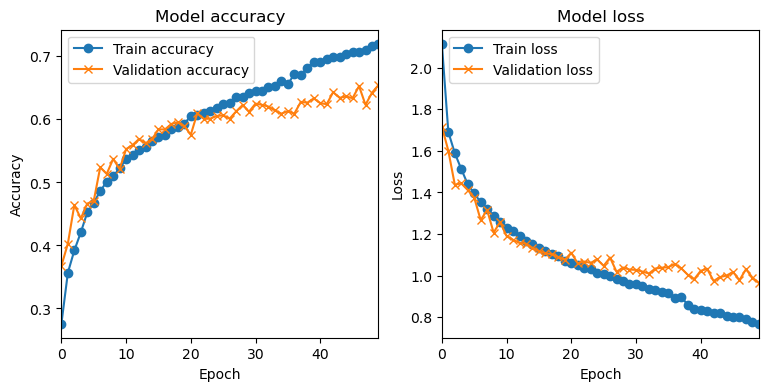

In [78]:
plot_training_and_validation_values(history)

# 🔍 Evaluation

In [34]:
def evaluate_model(model, training_set, test_set):
    train_loss, train_accuracy = model.evaluate(training_set)
    test_loss, test_accuracy = model.evaluate(test_set)
    print(
        "Final train accuracy is {:.2f}%, while test accuracy is {:.2f}%.".format(
            train_accuracy * 100, test_accuracy * 100
        )
    )

In [35]:
test_set_dir = working_dir + "/" + "PublicTest"
test_data_gen_args = dict(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(**test_data_gen_args)

In [37]:
test_image_generator = test_datagen.flow_from_directory(
    test_set_dir, target_size=(52, 52), batch_size=batch_size, class_mode="sparse", shuffle=False, 
    color_mode="grayscale"
)

test_crops = crop_generator(test_image_generator, 48)

Found 3251 images belonging to 7 classes.


In [38]:
evaluate_model(model_cnn, training_image_generator, test_image_generator)

102/102 [==============================] - 3s 25ms/step - loss: 1.0510 - accuracy: 0.6220
Final train accuracy is 76.23%, while test accuracy is 62.20%.


## Classification Results and Confusion Matrix

In [39]:
def get_confusion_matrix(model, test_set):
    y_pred = model.predict(test_set)
    y_pred = np.argmax(y_pred, axis=1)
    classes = test_set.class_indices
    classes = {label: number for number, label in classes.items()}
    confusion_mat = confusion_matrix(test_set.classes, y_pred)
    return confusion_mat

In [40]:
def get_classification_report(model, test_set, output_dict):
    y_pred = model.predict(test_set)
    y_pred = np.argmax(y_pred, axis=1)
    classes = test_set.class_indices
    classes = {label: number for number, label in classes.items()}
    target_names = list(classes.values())
    return classification_report(
        test_set.classes,
        y_pred,
        target_names=target_names,
        output_dict=output_dict,
        zero_division=1,
    )

In [41]:
def plot_confusion_mat(
    confusion_mat,
    labels,
    compare_mat=None,
    compare_labels=None,
    compare=False,
    figsize=(16, 6),
):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1, 2, 1)
    sns.heatmap(confusion_mat, annot=True, ax=ax, fmt="g", cmap="Blues")
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    if compare:
        ax = plt.subplot(1, 2, 2)
        sns.heatmap(compare_mat, annot=True, ax=ax, fmt="g", cmap="Blues")
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        ax.set_title("Balanced Confusion Matrix")
        ax.xaxis.set_ticklabels(compare_labels)
        ax.yaxis.set_ticklabels(compare_labels)

102/102 [==============================] - 2s 16ms/step


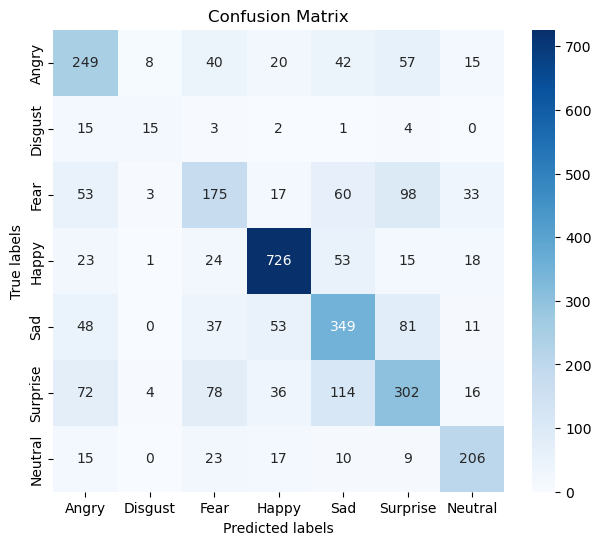

In [42]:
cm = get_confusion_matrix(model_cnn, test_image_generator)
plot_confusion_mat(cm, emotions)

In [43]:
report = get_classification_report(
    model_cnn, training_image_generator, output_dict=True
)
report_table = pd.DataFrame(report).transpose()
report_table

813/813 [==============================] - 18s 22ms/step


,precision,recall,f1-score,support
Angry,0.137144,0.131622,0.134326,3700.000000
Disgust,0.012461,0.012658,0.012559,316.000000
Fear,0.149316,0.128811,0.138307,3641.000000
Happy,0.265329,0.275543,0.270339,6910.000000
Neutral,0.184364,0.192997,0.188582,4741.000000
Sad,0.172805,0.172654,0.172729,4593.000000
Surprise,0.086534,0.093112,0.089703,2105.000000
accuracy,0.183342,0.183342,0.183342,0.183342
macro avg,0.143993,0.143914,0.143792,26006.000000
weighted avg,0.182203,0.183342,0.182605,26006.000000


# ⚖️ Balance Data

## ⛏️ Preprocess Data

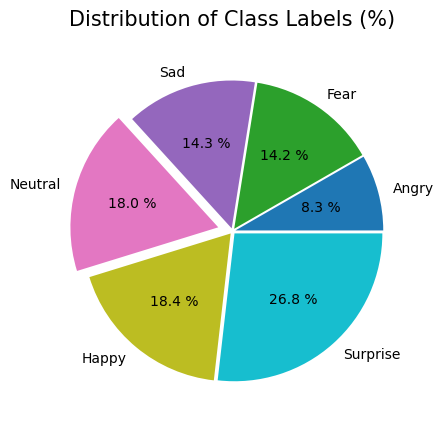

In [44]:
# During the balanced training the 'Disgust' class has been dropped due 
# to its effect of skewing the class weights. While keeping this class 
# in the balanced training, it resulted in poor learning. Further 
# research could reveal additional information on this class.

data_for_balanced = data[data["emotion_label"] != "Disgust"].reset_index()
balanced_label_counts = sorted(data_for_balanced.emotion.value_counts())
balanced_counts = [balanced_label_counts[i] for i in range(6)]
plt.title(
    "Distribution of Class Labels (%)", fontsize=15, pad=15
)
_ = plt.pie(
    x=balanced_counts,
    labels=list(data_for_balanced["emotion_label"].unique()),
    autopct="%3.1f %%",
    colors=get_colors("tab10", 6),
    explode=tuple([0.1 if x == np.argmax(counts) else 0.02 for x in range(6)]),
)

In [45]:
for data_usage_type in data_usage:
    folder_path = working_dir + "/" + data_usage_type + "/Disgust"
    try:
        shutil.rmtree(folder_path)
        print("Removed folder: ", folder_path)
    except FileNotFoundError:
        print("The folder ", folder_path, " does not exist.")

Removed folder:  /Users/reka/Downloads/Training/Disgust
Removed folder:  /Users/reka/Downloads/PublicTest/Disgust
Removed folder:  /Users/reka/Downloads/PrivateTest/Disgust


## 🚀 Data Augmentation

In [46]:
balanced_training_image_generator = image_datagen.flow_from_directory(
    training_set_dir, target_size=(52, 52), batch_size=batch_size, class_mode="sparse", color_mode="grayscale"
)

balanced_validation_image_generator = val_datagen.flow_from_directory(
    validation_set_dir, target_size=(52, 52), batch_size=batch_size, class_mode="sparse", color_mode="grayscale"
)

balanced_train_crops = crop_generator(balanced_training_image_generator, 48)
balanced_validation_crops = crop_generator(balanced_validation_image_generator, 48)

Found 25690 images belonging to 6 classes.
Found 3223 images belonging to 6 classes.


## 📈 Training

In [63]:
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes=np.unique(balanced_training_image_generator.classes),
                                        y = balanced_training_image_generator.classes)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.1572072072072073, 1: 1.1759589856266592, 2: 0.6196333815726001, 3: 0.9031146734162976, 4: 0.9322156905435808, 5: 2.0340459224069676}


In [64]:
training_set_size = len(data_for_balanced[data_for_balanced["Usage"] == "Training"])
validation_set_size = len(data_for_balanced[data_for_balanced["Usage"] == "PrivateTest"])
print(
    "Traning set size: ",
    training_set_size,
    "Validation set size: ",
    validation_set_size,
)

Traning set size:  25690 Validation set size:  3223


In [67]:
balanced_model = get_model(classes=6)

In [68]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="balanced_cp.ckpt", save_weights_only=True, verbose=1, save_best_only=True,
)

In [69]:
balanced_history = balanced_model.fit(
    balanced_train_crops,
    steps_per_epoch=training_set_size // batch_size,
    epochs=50,
    callbacks=[
        early_stopping,
        reduce_lr,
        model_checkpoint,
    ],
    validation_data=balanced_validation_crops,
    validation_steps=validation_set_size // batch_size,
    class_weight=class_weights,
)

Epoch 1/50
802/802 [==============================] - ETA: 0s - loss: 2.1034 - accuracy: 0.2551
Epoch 1: val_loss improved from inf to 1.61621, saving model to balanced_cp.ckpt
802/802 [==============================] - 53s 65ms/step - loss: 2.1034 - accuracy: 0.2551 - val_loss: 1.6162 - val_accuracy: 0.3606 - lr: 1.0000e-04
Epoch 2/50
802/802 [==============================] - ETA: 0s - loss: 1.7315 - accuracy: 0.3140
Epoch 2: val_loss improved from 1.61621 to 1.55008, saving model to balanced_cp.ckpt
802/802 [==============================] - 53s 64ms/step - loss: 1.7315 - accuracy: 0.3140 - val_loss: 1.5501 - val_accuracy: 0.3808 - lr: 1.0000e-04
Epoch 3/50
802/802 [==============================] - ETA: 0s - loss: 1.6180 - accuracy: 0.3593
Epoch 3: val_loss improved from 1.55008 to 1.49716, saving model to balanced_cp.ckpt
802/802 [==============================] - 56s 70ms/step - loss: 1.6180 - accuracy: 0.3593 - val_loss: 1.4972 - val_accuracy: 0.4124 - lr: 1.0000e-04
Epoch 4/50


Epoch 27/50
802/802 [==============================] - ETA: 0s - loss: 1.0227 - accuracy: 0.6222
Epoch 27: val_loss did not improve from 1.03172
802/802 [==============================] - 66s 83ms/step - loss: 1.0227 - accuracy: 0.6222 - val_loss: 1.0924 - val_accuracy: 0.5819 - lr: 1.0000e-04
Epoch 28/50
802/802 [==============================] - ETA: 0s - loss: 1.0012 - accuracy: 0.6282
Epoch 28: val_loss improved from 1.03172 to 1.02807, saving model to balanced_cp.ckpt
802/802 [==============================] - 66s 82ms/step - loss: 1.0012 - accuracy: 0.6282 - val_loss: 1.0281 - val_accuracy: 0.6039 - lr: 1.0000e-04
Epoch 29/50
802/802 [==============================] - ETA: 0s - loss: 1.0000 - accuracy: 0.6298
Epoch 29: val_loss did not improve from 1.02807
802/802 [==============================] - 67s 83ms/step - loss: 1.0000 - accuracy: 0.6298 - val_loss: 1.0454 - val_accuracy: 0.6130 - lr: 1.0000e-04
Epoch 30/50
802/802 [==============================] - ETA: 0s - loss: 0.9797

### Plot Accuracy and Loss for Training and Validation Sets

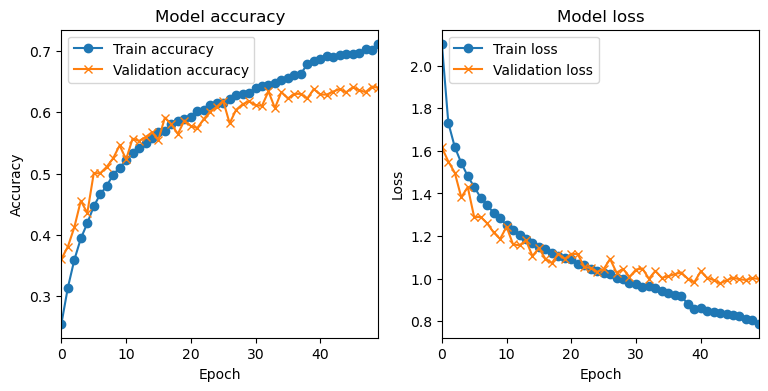

In [80]:
plot_training_and_validation_values(balanced_history)

## 🔍 Evaluation

In [71]:
balanced_test_image_generator = test_datagen.flow_from_directory(
    test_set_dir, target_size=(52, 52), batch_size=batch_size, class_mode="sparse", shuffle=False,
    color_mode="grayscale"
)

balanced_test_crops = crop_generator(test_image_generator, 48)
evaluate_model(
    balanced_model, balanced_training_image_generator, balanced_test_image_generator
)

Found 3211 images belonging to 6 classes.
101/101 [==============================] - 3s 25ms/step - loss: 1.0538 - accuracy: 0.6188
Final train accuracy is 74.78%, while test accuracy is 61.88%.


### Classification Results and Confusion Matrix

101/101 [==============================] - 2s 16ms/step


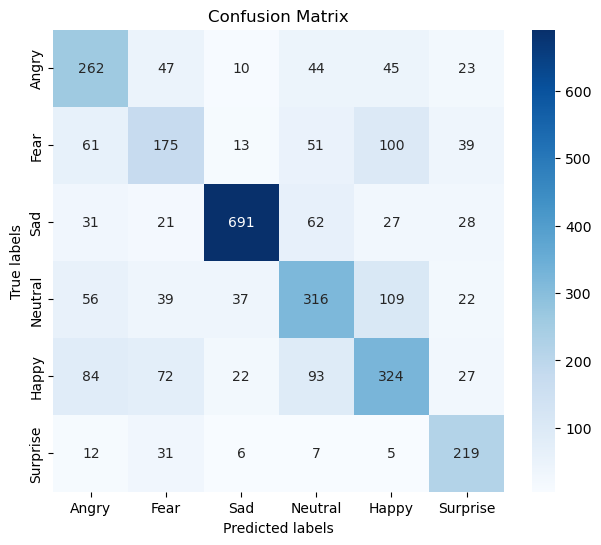

In [72]:
balanced_cm = get_confusion_matrix(balanced_model, balanced_test_image_generator)
plot_confusion_mat(balanced_cm, list(data_for_balanced["emotion_label"].unique()))

In [73]:
balanced_report = get_classification_report(
    balanced_model, balanced_test_image_generator, True
)
balanced_report_table = pd.DataFrame(balanced_report).transpose()
balanced_report_table

101/101 [==============================] - 2s 18ms/step


,precision,recall,f1-score,support
Angry,0.517787,0.607889,0.559232,431.00000
Fear,0.454545,0.398633,0.424757,439.00000
Happy,0.887035,0.803488,0.843197,860.00000
Neutral,0.551483,0.545769,0.548611,579.00000
Sad,0.531148,0.520900,0.525974,622.00000
Surprise,0.611732,0.782143,0.686520,280.00000
accuracy,0.618810,0.618810,0.618810,0.61881
macro avg,0.592288,0.609804,0.598049,3211.00000
weighted avg,0.624892,0.618810,0.619643,3211.00000


# 📝 Comparing the Models

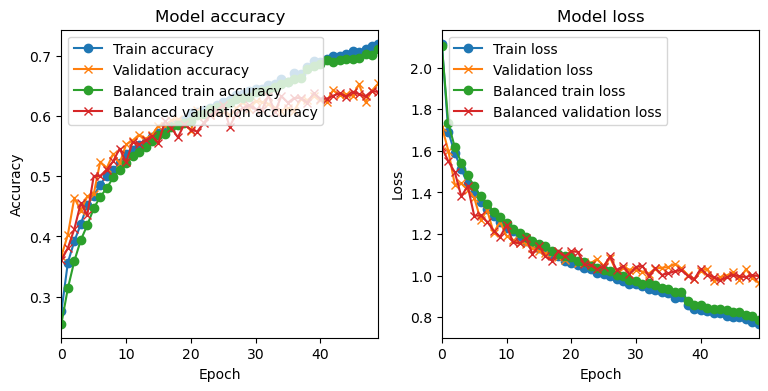

In [79]:
plot_training_and_validation_values(history, balanced_history, compare=True)

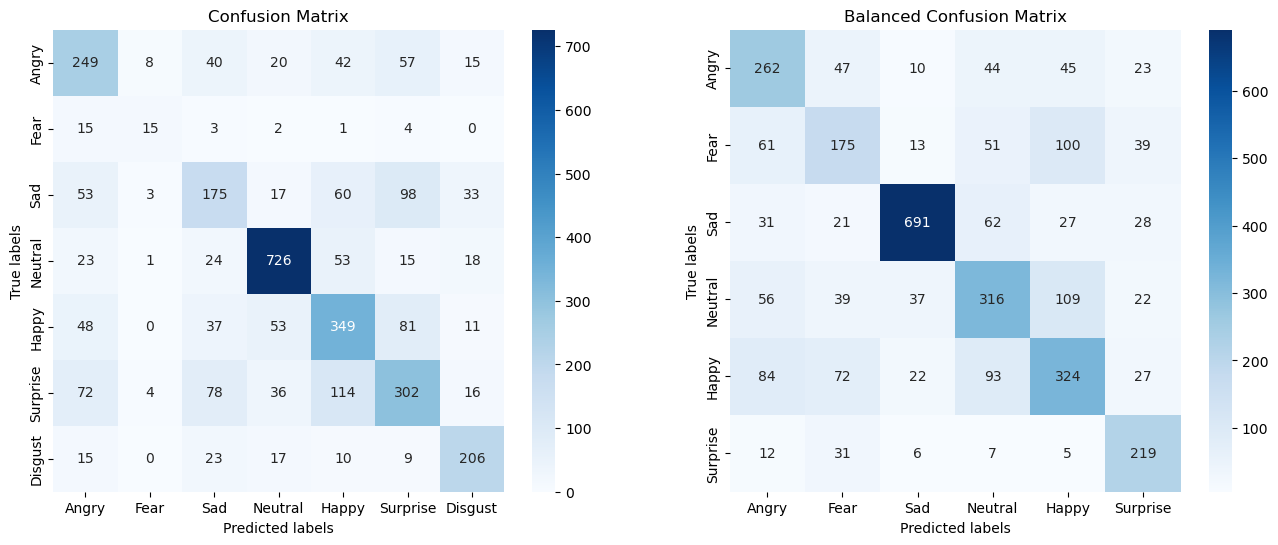

In [75]:
plot_confusion_mat(
    cm,
    list(data["emotion_label"].unique()),
    balanced_cm,
    list(data_for_balanced["emotion_label"].unique()),
    compare=True
)